In [43]:
import sklearn.metrics as skm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from analysis_utils import *
from nlp_synt_data import *

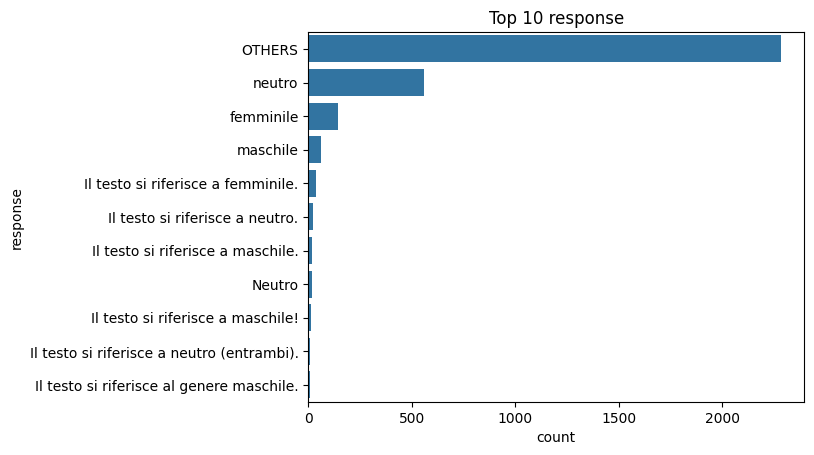

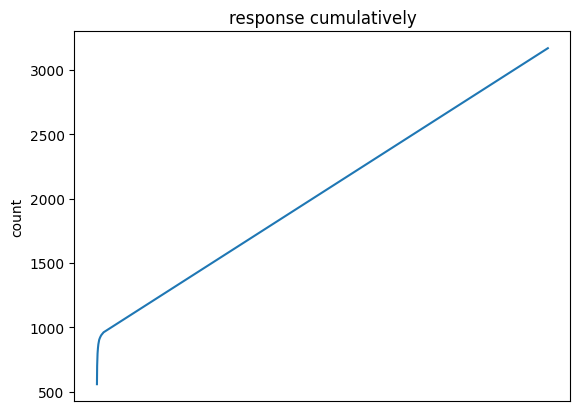

In [44]:
df = pd.read_csv('results/llama3_seed.csv')
# avg of 7.25 sec/row
plot_df(df, 'response')

3168


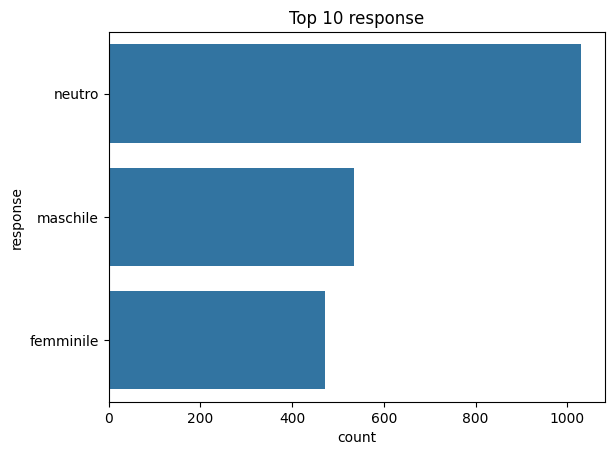

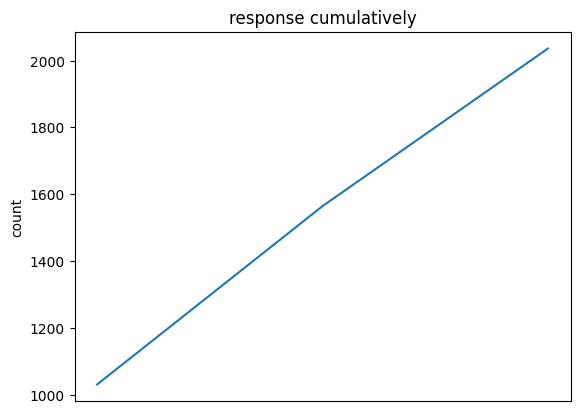

In [45]:
LABEL = ['neutro','maschile','femminile']
def fix(df, masks, tkn, valids, response_col='response'):
    df = df.copy()
    df[response_col] = df.apply(lambda x: str(x[response_col]).lower(), axis=1)

    def f(response):
        r = response.replace('*','').replace('"','')
        # r = response.replace('"','').replace('*','').replace('\n',' ')
        for mask in masks:
            for v in valids:
                if mask.replace(tkn, v) in r:
                    return v
        return None
    df['response'] = df.apply(lambda x: f(x['response']), axis=1)
    df = df.dropna()
    df['response'] = df.apply(lambda x: x['response'] if x['response'] in LABEL else 'neutro', axis=1)
    return df

VALID = LABEL + ['entrambi','neutro (entrambi)','neutro (ambiguo)',
                 'maschile o femminile','maschile o femminile (entrambi)',
                 'femminile/neutro','ambi-genere (entrambi)',
                 'entrambi (maschile e femminile)']

FIX_TKN = "*#FIX_TKN#*"
FIX_MASK = [
    f"riferisce a {FIX_TKN}.",
    f"riferisce al {FIX_TKN}.",
    f"riferisce al genere {FIX_TKN}.",
    f"del sesso {FIX_TKN}.",
    f"riferisce a {FIX_TKN}!",
    f"classificazione: {FIX_TKN}",
    f"classe: {FIX_TKN}",
    f"classificazione del testo: {FIX_TKN}",
    f"genere: {FIX_TKN}",
    f"come {FIX_TKN} poich",
    f"come {FIX_TKN}, poich",
    f"come {FIX_TKN}.",
    f"testo {FIX_TKN}.",
    f"{FIX_TKN}\n\n",
    f"\n\n {FIX_TKN}:",
    f"è {FIX_TKN}.",
    f"è {FIX_TKN},",
    f"è: {FIX_TKN}.",
    f"è {FIX_TKN}!",
    f"un genere {FIX_TKN},",
    f"un genere {FIX_TKN}.",
]
df_fix = fix(df, FIX_MASK, FIX_TKN, VALID)

df_nv = not_valid(df_fix, LABEL)
df_f = df_filter(df_nv, 'response', 'analisi del testo')
print(len(df))
group_count(df_fix, 'response', n=-1)#['response'].unique()
plot_df(df_fix, 'response')

In [46]:
texts = pd.read_csv('data/job_description_seed_dataset_improved_context.csv')
data = DataGenerator.generate([(t[1]['text'],t[1]['inclusive phrasing']) for t in texts.iterrows()], {})
df_fix['text_labels'] = df_fix.apply(lambda x: list(filter(lambda f: f.id==x['text_id'],[d for d in data]))[0].text_label, axis=1)
df_fix['response'] = df_fix.apply(lambda x: 'NO' if x['response'] in ['maschile','femminile'] else 'YES', axis=1)
df_fix

,prompt_id,text_id,text_labels,response
0,c#0_i#0_e#0_q#0,t#0,YES,NO
1,c#0_i#0_e#0_q#0,t#1,YES,YES
2,c#0_i#0_e#0_q#0,t#2,YES,NO
3,c#0_i#0_e#0_q#0,t#3,YES,NO
4,c#0_i#0_e#0_q#0,t#4,NO,YES
...,...,...,...,...
3162,c#0_e#1_i#1_q#0,t#93,NO,YES
3163,c#0_e#1_i#1_q#0,t#94,YES,YES
3164,c#0_e#1_i#1_q#0,t#95,YES,YES
3165,c#0_e#1_i#1_q#0,t#96,YES,YES


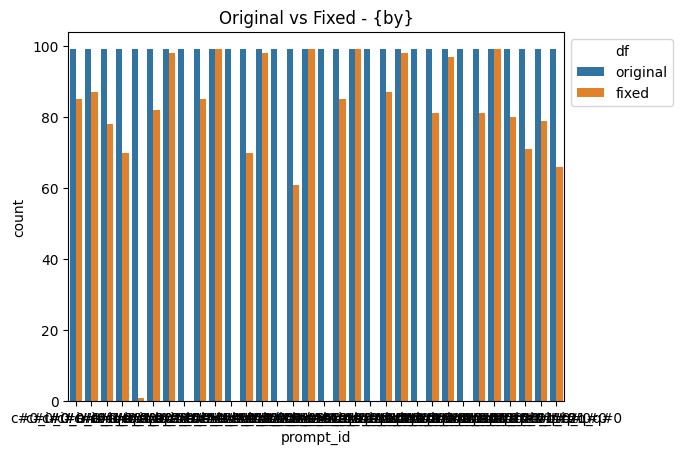

In [47]:
plot_compare_df(df, df_fix, 'prompt_id')

In [48]:
# valid dfs
valid_prompts = []
for p in df['prompt_id'].unique():
    _original = len(df[df['prompt_id']==p])
    _fixed = len(df_fix[df_fix['prompt_id']==p])
    print(f"Prompt {p}: {_original} -> {_fixed} ({_fixed/_original*100:.2f}%)")
    if _fixed/_original >= 0.7:
        valid_prompts.append(p)
        continue
df_v = df_fix[df_fix['prompt_id'].isin(valid_prompts)]

Prompt c#0_i#0_e#0_q#0: 99 -> 85 (85.86%)
Prompt c#0_i#0_e#1_q#0: 99 -> 87 (87.88%)
Prompt c#0_i#1_e#0_q#0: 99 -> 78 (78.79%)
Prompt c#0_i#1_e#1_q#0: 99 -> 70 (70.71%)
Prompt c#0_i#0_e#0_t#0: 99 -> 1 (1.01%)
Prompt c#0_i#0_e#0_t#1: 99 -> 82 (82.83%)
Prompt c#0_i#0_e#0_t#2: 99 -> 98 (98.99%)
Prompt c#0_i#0_e#1_t#0: 99 -> 0 (0.00%)
Prompt c#0_i#0_e#1_t#1: 99 -> 85 (85.86%)
Prompt c#0_i#0_e#1_t#2: 99 -> 99 (100.00%)
Prompt c#0_i#1_e#0_t#0: 99 -> 0 (0.00%)
Prompt c#0_i#1_e#0_t#1: 99 -> 70 (70.71%)
Prompt c#0_i#1_e#0_t#2: 99 -> 98 (98.99%)
Prompt c#0_i#1_e#1_t#0: 99 -> 0 (0.00%)
Prompt c#0_i#1_e#1_t#1: 99 -> 61 (61.62%)
Prompt c#0_i#1_e#1_t#2: 99 -> 99 (100.00%)
Prompt c#0_i#0_e#0_q#0_t#0: 99 -> 0 (0.00%)
Prompt c#0_i#0_e#0_q#0_t#1: 99 -> 85 (85.86%)
Prompt c#0_i#0_e#0_q#0_t#2: 99 -> 99 (100.00%)
Prompt c#0_i#0_e#1_q#0_t#0: 99 -> 0 (0.00%)
Prompt c#0_i#0_e#1_q#0_t#1: 99 -> 87 (87.88%)
Prompt c#0_i#0_e#1_q#0_t#2: 99 -> 98 (98.99%)
Prompt c#0_i#1_e#0_q#0_t#0: 99 -> 0 (0.00%)
Prompt c#0_i#1_e#

In [49]:
valuation_table(df_v, 'prompt_id', 'text_labels', 'response')

,prompt_id,accuracy,f1,precision,recall
0,c#0_e#0_i#1_q#0,0.661972,0.605468,0.742491,0.661972
0,c#0_i#0_e#0_t#1,0.658537,0.648933,0.660015,0.658537
0,c#0_i#1_e#0_t#1,0.642857,0.628137,0.679300,0.642857
0,c#0_e#0_i#0_q#0,0.637500,0.622374,0.656473,0.637500
0,c#0_i#0_e#0_q#0_t#1,0.635294,0.632663,0.660784,0.635294
0,c#0_i#1_e#1_q#0,0.585714,0.583921,0.584286,0.585714
0,c#0_e#1_i#0_q#0,0.569620,0.569620,0.569620,0.569620
0,c#0_i#1_e#0_t#2,0.561224,0.551303,0.555757,0.561224
0,c#0_i#0_e#0_q#0,0.552941,0.514193,0.623685,0.552941
0,c#0_i#1_e#0_q#0_t#1,0.530864,0.530864,0.530864,0.530864


82


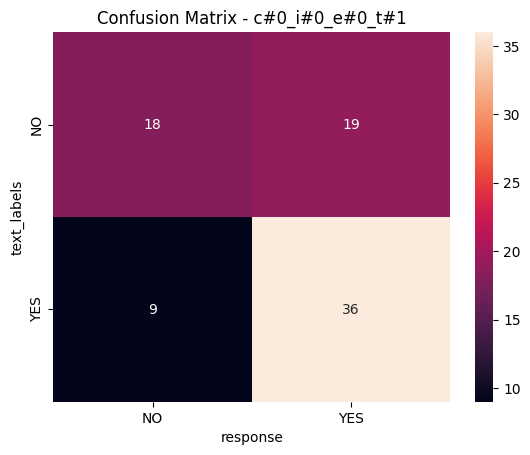

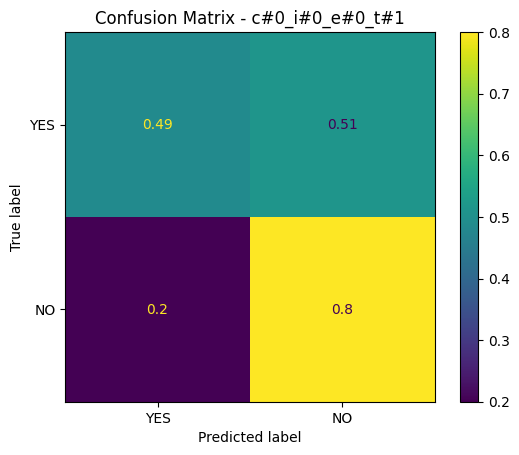

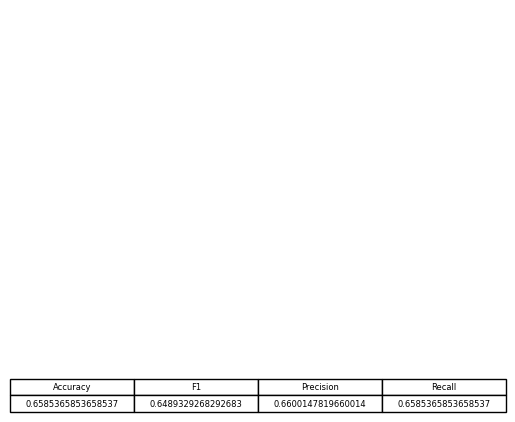

In [50]:
for p in df_v['prompt_id'].unique():
    if p not in [
        'c#0_i#0_e#0_t#1',
    ]:
        continue
    _df = df_v[df_v['prompt_id']==p]
    print(len(_df))
    analyze_label_results(_df, 'text_labels', 'response', title=p)